In [146]:
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


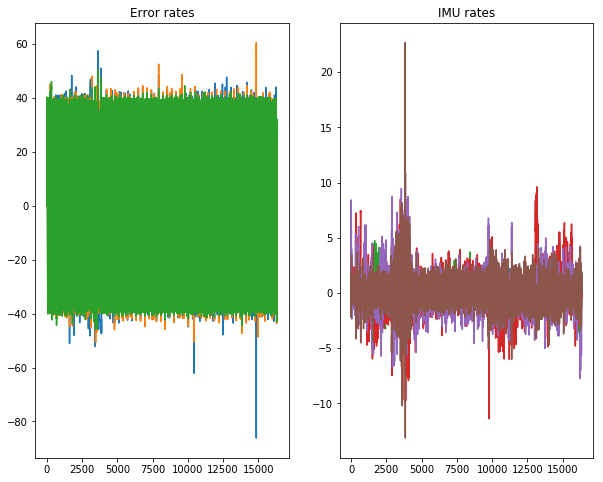

In [197]:
# Import data without time stamps
y_data = (np.genfromtxt('../small_images2/errors.csv', delimiter=',')[:,1:4]).astype(np.float32)
imu_data = (np.genfromtxt('../small_images2/rates.csv', delimiter=',')[:,1:7]).astype(np.float32)
imu_data = imu_data - imu_data.mean(axis=0)
sin_data = np.sin(np.linspace(0,1000,y_data.shape[0])).reshape(y_data.shape[0],1);
y_data += 40*sin_data
imu_data += sin_data
plt.subplot(1,2,1)
plt.title('Error rates')
plt.plot(y_data)
plt.subplot(1,2,2)
plt.title('IMU rates')
plt.plot(imu_data)

# sample batch_size subsequences of length sequence_length, and return the label at the end of the sequence
def sample_minibatch(sequence_length, batch_size):
    x_batch = np.zeros((batch_size, sequence_length, imu_data.shape[1]))
    y_batch = np.zeros((batch_size, y_data.shape[1]))
    for k in range(batch_size):
        # randomly sample endpoint:
        i_stop = np.random.randint(sequence_length, imu_data.shape[0])
        x_batch[k, :, :] = imu_data[i_stop-sequence_length:i_stop,:]
        y_batch[k,:] = y_data[sequence_length,:]
    return x_batch, y_batch

def calc_rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [144]:

SAVE_PATH = './basic_net.ckpt'
#model = SqueezeNet(save_path=SAVE_PATH, sess=sess)

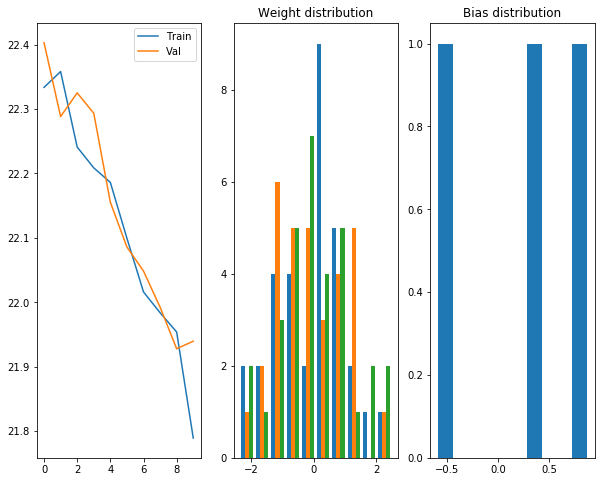

Iter 10, Minibatch RMSE= 21.789318, Validation RMSE= 21.93956


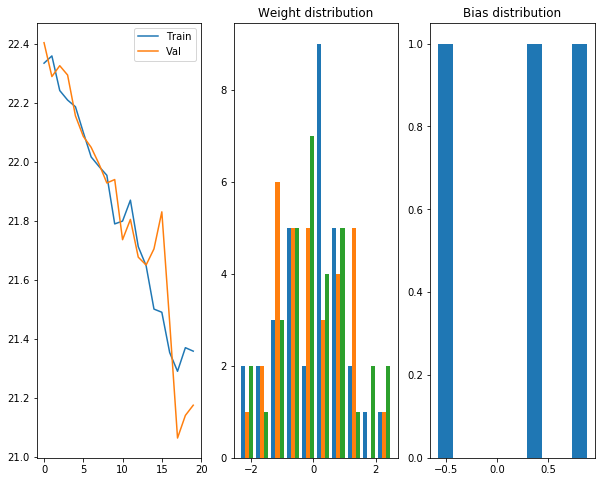

Iter 20, Minibatch RMSE= 21.358431, Validation RMSE= 21.17539


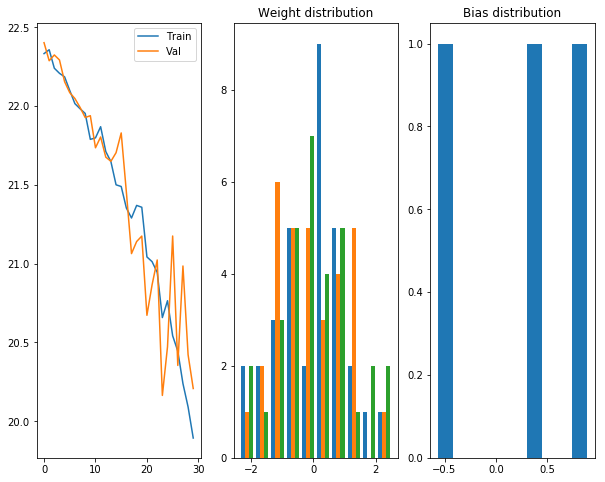

Iter 30, Minibatch RMSE= 19.893589, Validation RMSE= 20.20785


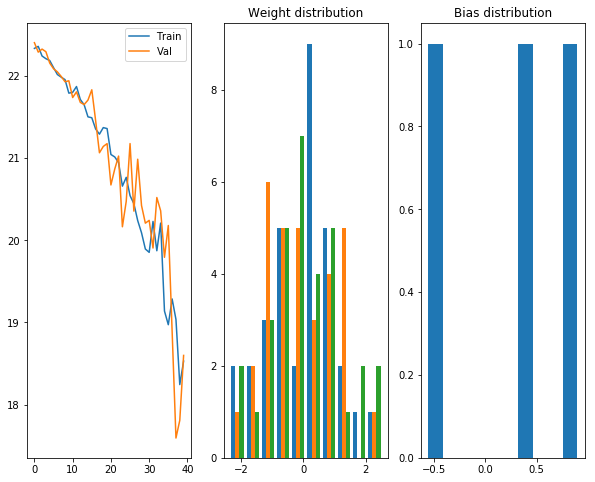

Iter 40, Minibatch RMSE= 18.530010, Validation RMSE= 18.59917


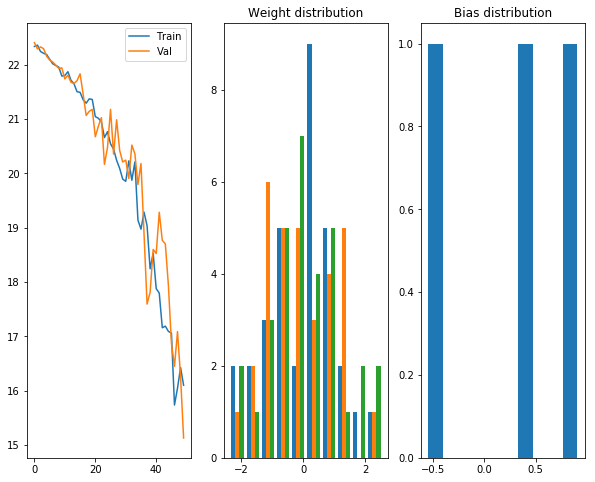

Iter 50, Minibatch RMSE= 16.102350, Validation RMSE= 15.13034


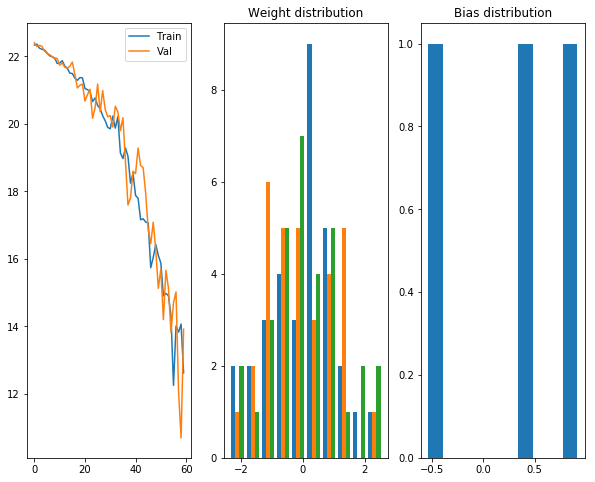

Iter 60, Minibatch RMSE= 12.624104, Validation RMSE= 13.91938


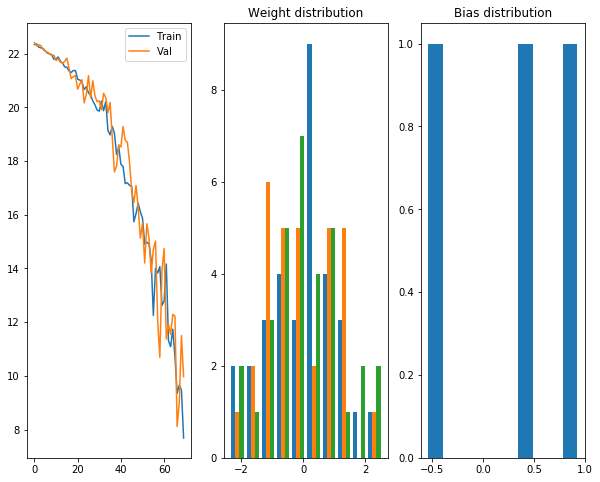

Iter 70, Minibatch RMSE= 7.689882, Validation RMSE= 9.97331


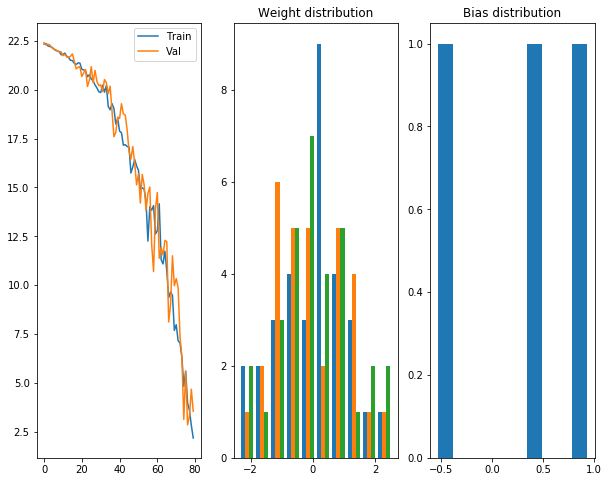

Iter 80, Minibatch RMSE= 2.184383, Validation RMSE= 3.55126


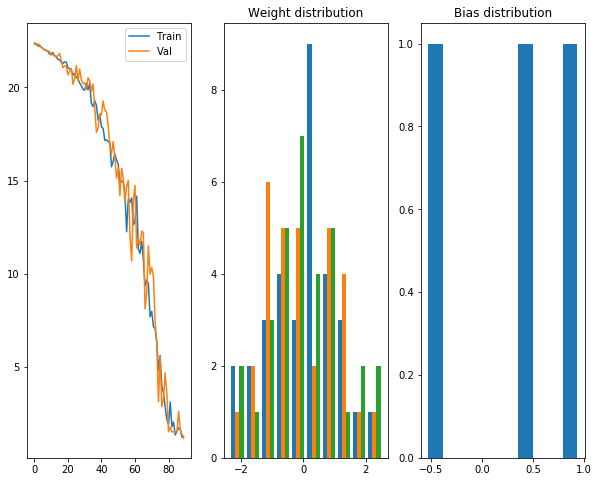

Iter 90, Minibatch RMSE= 1.268548, Validation RMSE= 1.18231


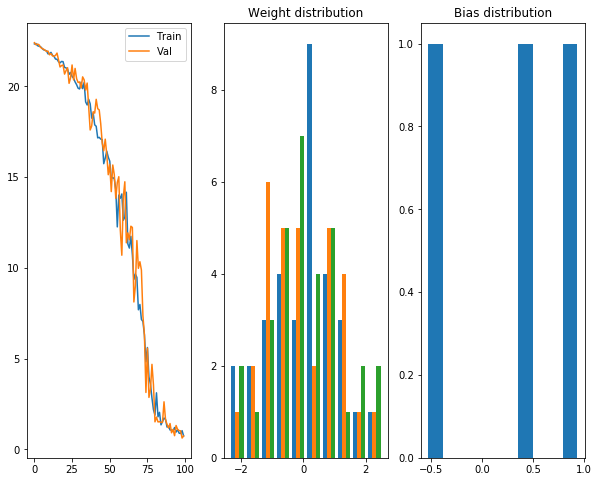

Iter 100, Minibatch RMSE= 0.741112, Validation RMSE= 0.73824


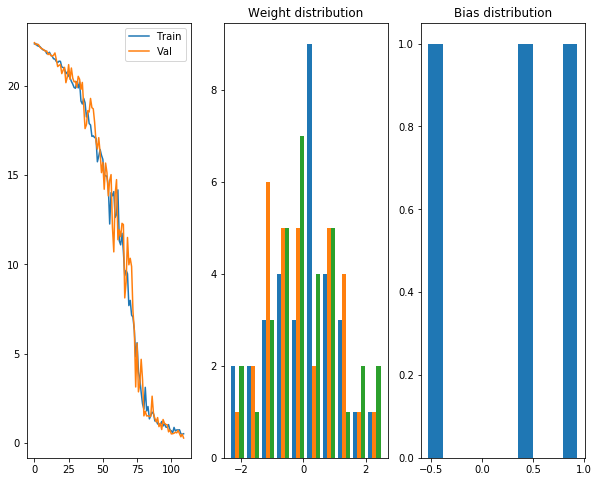

Iter 110, Minibatch RMSE= 0.518511, Validation RMSE= 0.27863


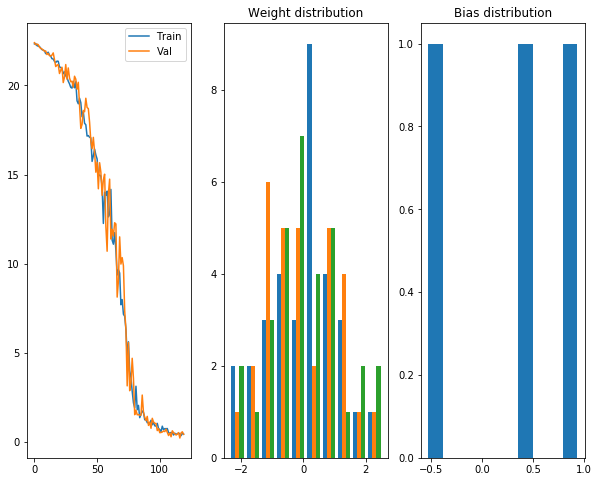

Iter 120, Minibatch RMSE= 0.426641, Validation RMSE= 0.41661


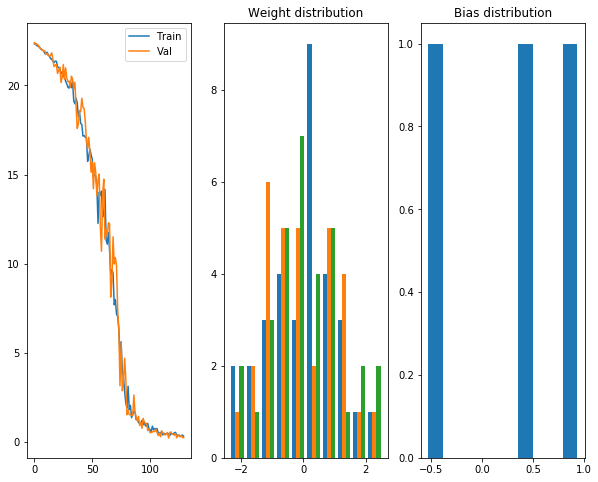

Iter 130, Minibatch RMSE= 0.308873, Validation RMSE= 0.23202


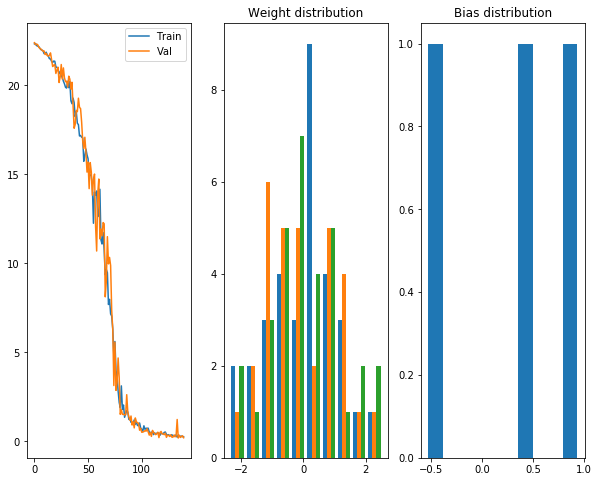

Iter 140, Minibatch RMSE= 0.257769, Validation RMSE= 0.20073


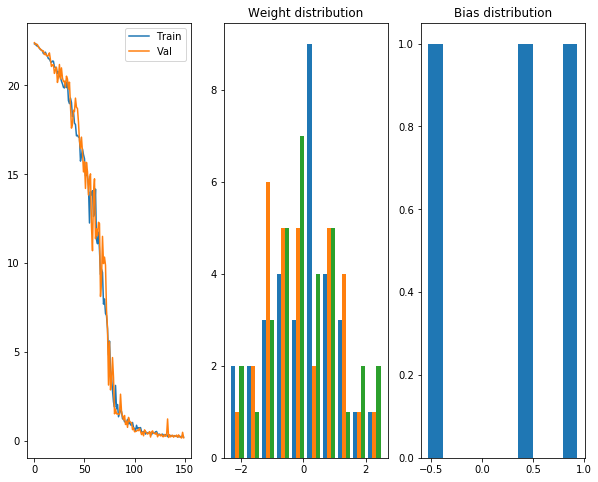

Iter 150, Minibatch RMSE= 0.205211, Validation RMSE= 0.16863


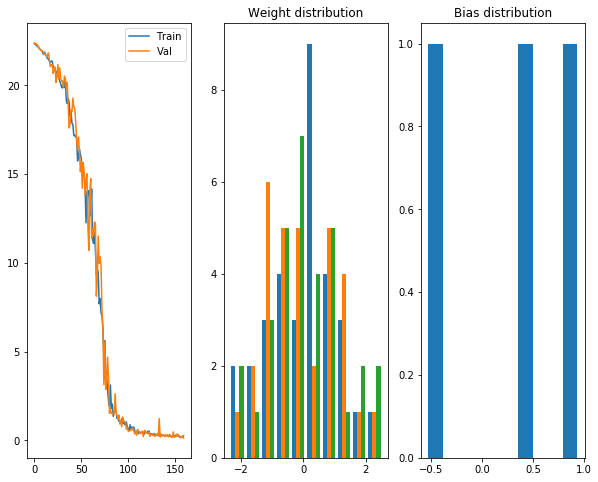

Iter 160, Minibatch RMSE= 0.249571, Validation RMSE= 0.12578


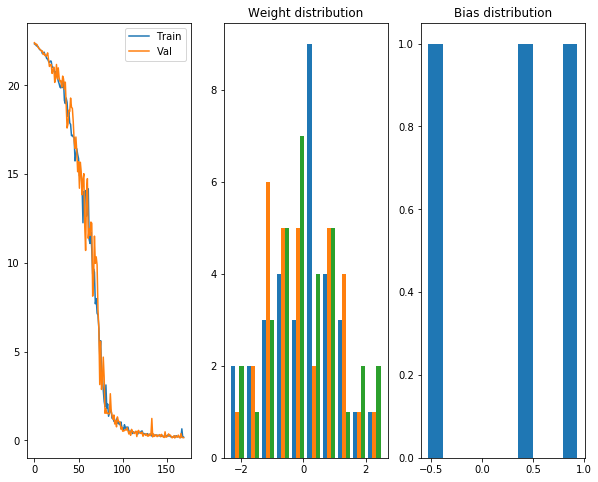

Iter 170, Minibatch RMSE= 0.167573, Validation RMSE= 0.14281


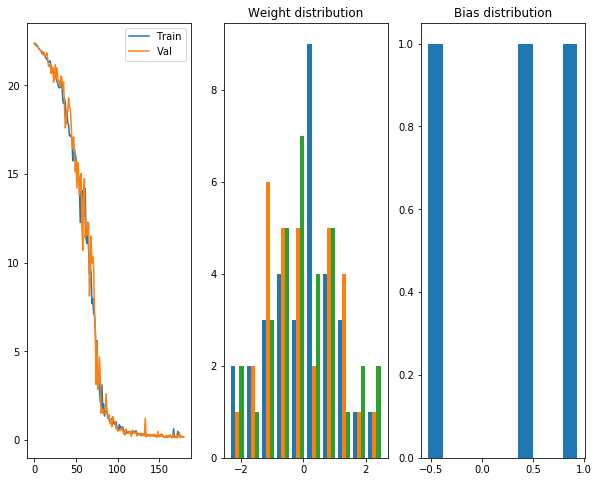

Iter 180, Minibatch RMSE= 0.183476, Validation RMSE= 0.18399


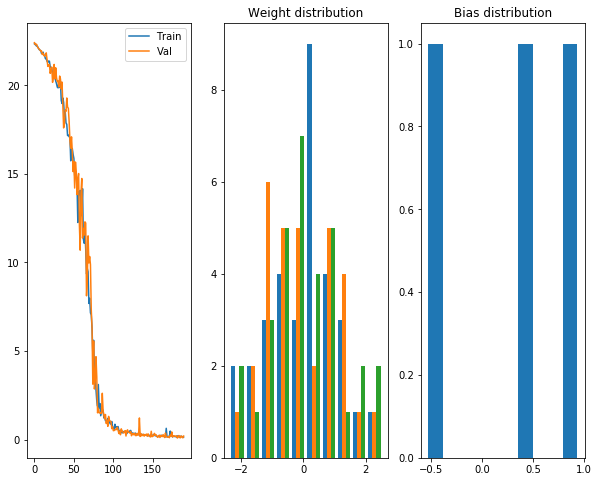

Iter 190, Minibatch RMSE= 0.141236, Validation RMSE= 0.20514


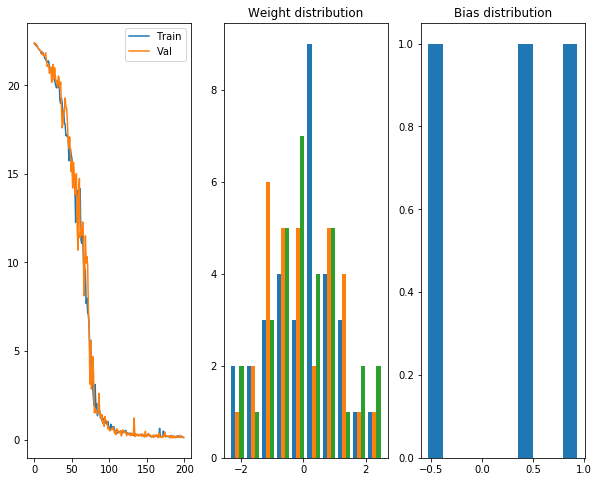

Iter 200, Minibatch RMSE= 0.122598, Validation RMSE= 0.12982


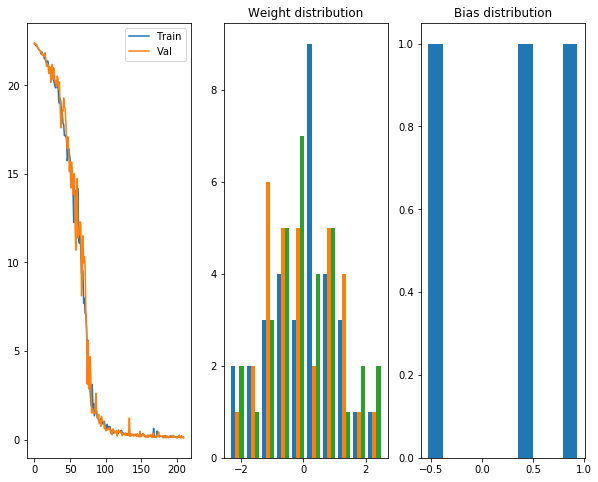

Iter 210, Minibatch RMSE= 0.150533, Validation RMSE= 0.09550


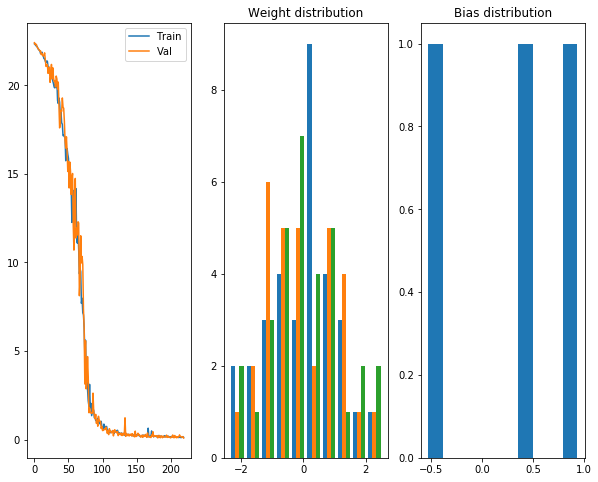

Iter 220, Minibatch RMSE= 0.126335, Validation RMSE= 0.08656


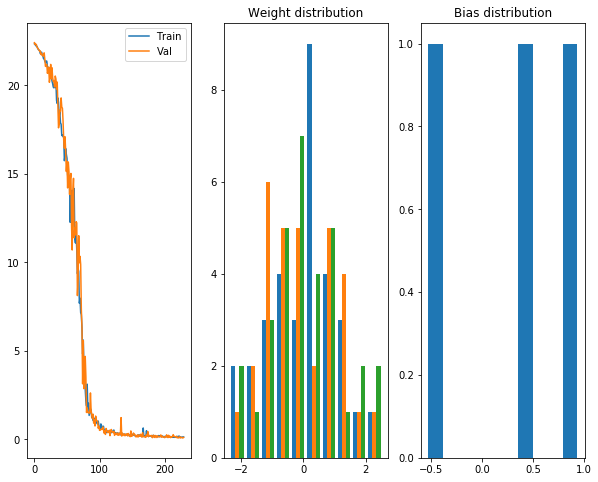

Iter 230, Minibatch RMSE= 0.138815, Validation RMSE= 0.11234


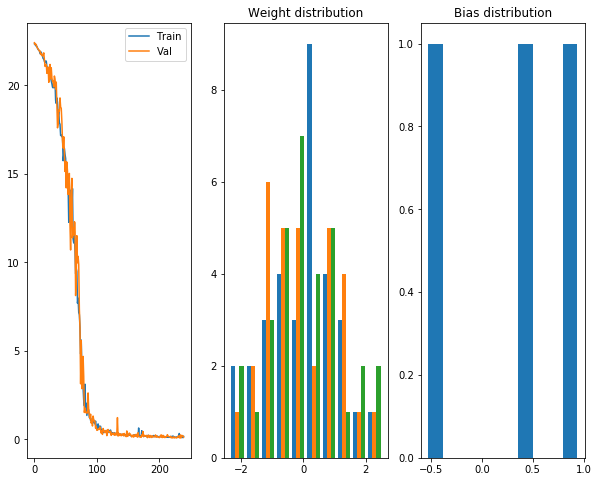

Iter 240, Minibatch RMSE= 0.167575, Validation RMSE= 0.12595


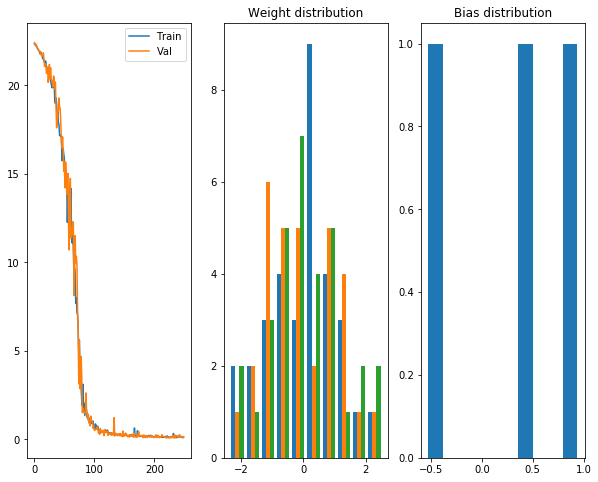

Iter 250, Minibatch RMSE= 0.128374, Validation RMSE= 0.13327


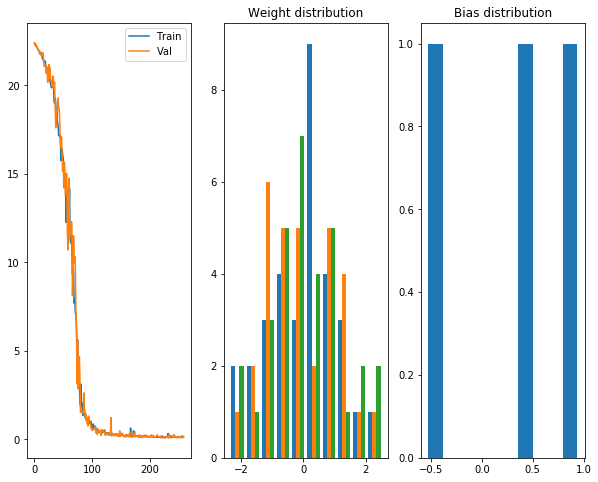

Iter 260, Minibatch RMSE= 0.142475, Validation RMSE= 0.16761


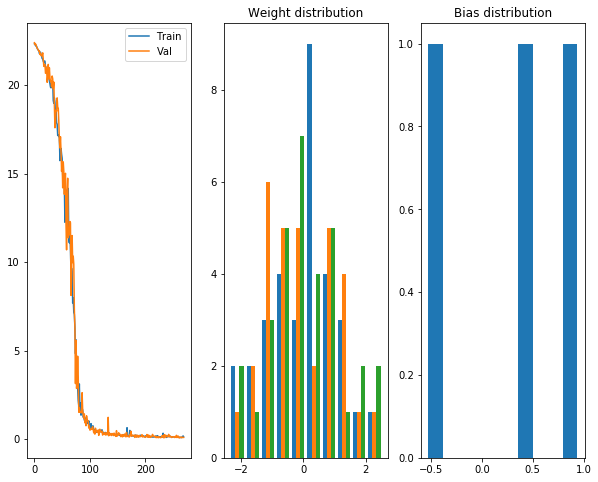

Iter 270, Minibatch RMSE= 0.125307, Validation RMSE= 0.09296


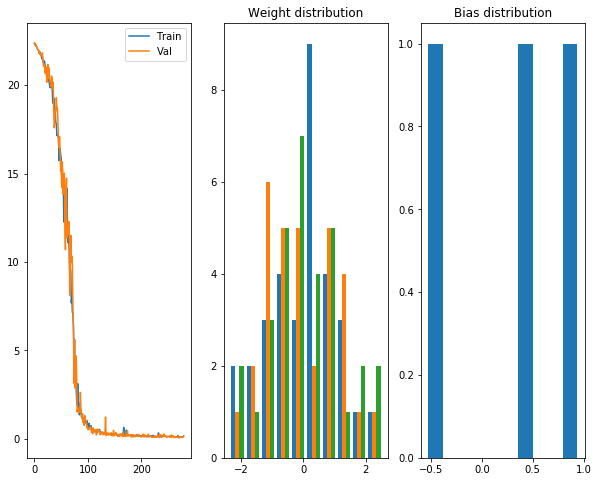

Iter 280, Minibatch RMSE= 0.148851, Validation RMSE= 0.13521


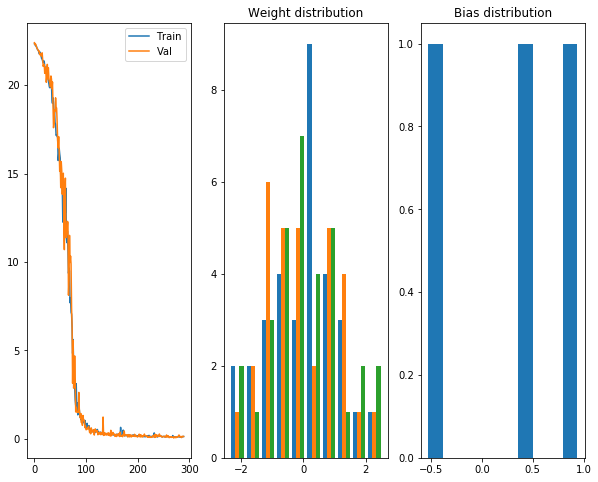

Iter 290, Minibatch RMSE= 0.128866, Validation RMSE= 0.12164
Optimization Finished!
Computing Sequence prediction - this may take a while...
step  1000
step  2000
step  3000
step  4000
step  5000
step  6000
step  7000
step  8000
step  9000
step  10000
step  11000
step  12000
step  13000
step  14000
step  15000
step  16000


In [198]:
# Start off with a simple RNN
tf.reset_default_graph()
sess = get_session()

# Parameters
learning_rate = 0.001
training_iters = 300
batch_size = 50
display_step = 10

# Network Parameters
n_imu_input = 6  # Size of imu input
n_steps = 10      # timesteps/history in each sample.
n_hidden = 32   # hidden layer num of features
n_train  = imu_data.shape[0] # number of training data available
n_output = 3     # Dimension of output space

x_imu = tf.placeholder("float32", [None, n_steps, n_imu_input])
y = tf.placeholder("float32", [None, n_output])

# Define weights
weights = tf.Variable(tf.random_normal([n_hidden, n_output]))
biases =  tf.Variable(tf.random_normal([n_output]))

# compute the RNN side of the graph
def RNN(x, weights, biases):
    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x_imu, n_steps, 1)

    # Define a lstm cell with tensorflo
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)

    # Get lstm cell output
    o1, states = tf.contrib.rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
    # add a dense layer:
    #, kernel_regularizer=tf.contrib.layers.l2_regularizer, 
    o2 = tf.layers.dense(o1[-1], n_hidden,activation=tf.nn.relu)
    o3 = tf.layers.dense(o2, n_hidden, activation=tf.nn.relu)
    # Linear activation, using rnn inner loop last output
    return tf.matmul(o3, weights) + biases

# TODO: compute the CNN side of the graph


# Stitch together:

pred = RNN(x_imu, weights, biases)
# Define loss and optimizer
rmse = tf.sqrt(tf.reduce_mean( tf.squared_difference(y, pred)))
#rmse,tmp = tf.metrics.root_mean_squared_error(y_data, pred)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(rmse)


# Initializing the variables
init = tf.global_variables_initializer()

train_history = []
val_history = []

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step  < training_iters:
        # these batches are of size 1?
        # for now, just grab a random sequence of data:
        batch_x, batch_y = sample_minibatch(n_steps, batch_size)
        
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x_imu: batch_x, y: batch_y})
        # Calculate batch accuracy
        mse = sess.run(rmse, feed_dict={x_imu: batch_x, y: batch_y})
        
        batch_xval, batch_yval = sample_minibatch(n_steps, 10)        
        long_mse = sess.run(rmse, feed_dict={x_imu: batch_xval, y: batch_yval})
        train_history.append(mse)
        val_history.append(long_mse)
        
        if step % display_step == 0:
            w = sess.run(weights)
            b = sess.run(biases)
            plt.clf()
            plt.subplot(1,3,1)
            plt.plot(train_history)
            plt.plot(val_history)
            plt.legend(['Train', 'Val'])
            plt.subplot(1,3,2)
            plt.title('Weight distribution')
            plt.hist(w)
            plt.subplot(1,3,3)
            plt.title('Bias distribution')
            plt.hist(b)
            plt.show()
            print("Iter " + str(step) + ", Minibatch RMSE= " + \
                  "{:.6f}".format(mse) + ", Validation RMSE= " + \
                  "{:.5f}".format(long_mse))
        step += 1
    print("Optimization Finished!")
    
    w = sess.run(weights)
    
    # Plot predictions:
    print("Computing Sequence prediction - this may take a while...")
    y_pred = np.zeros((n_train, n_output))  
    for k in range(n_steps, n_train):
        if k%1000 == 0:
            print('step ', k)
        xk = imu_data[k-n_steps:k,:].reshape(1,n_steps,n_imu_input)
        y_pred[k,:] = sess.run(pred, feed_dict={x_imu: xk})



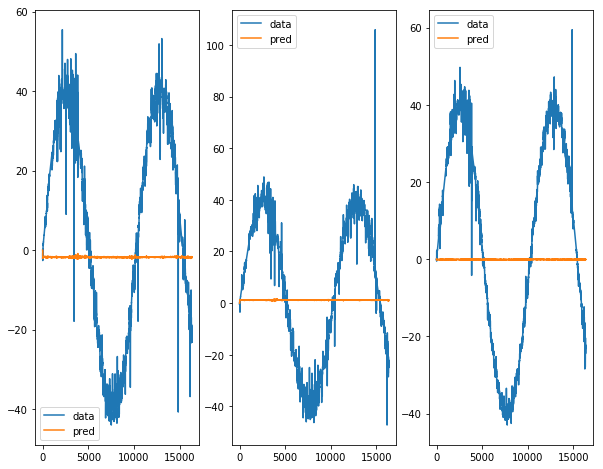

In [196]:
for k in range(3):
    plt.subplot(1,3,k+1)
    plt.plot(y_data[:,k])
    plt.plot(y_pred[:,k])
    plt.legend(['data','pred'])
#plt.legend(['x: pred', 'y: pred', 'z: pred', 'x: true', 'y: true', 'z: true'])
#for k in range(n_steps, n_train):
#    print(k-n_steps, k, imu_data[k-n_steps:k, 1])
#    xk = imu_data[k-n_steps:k,:].reshape(1,n_steps,n_imu_input)


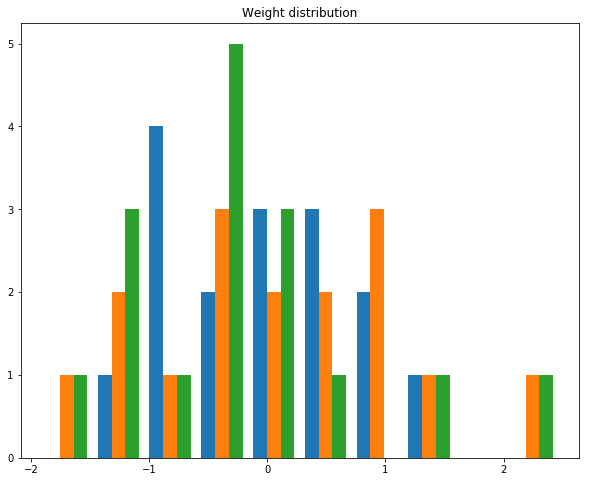

In [150]:
plt.title('Weight distribution')
plt.hist(w)
plt.show()

In [ ]:
# Just here as reference - squeezenet from hw3


import tensorflow as tf

NUM_CLASSES = 1000

def fire_module(x,inp,sp,e11p,e33p):
    with tf.variable_scope("fire"):
        with tf.variable_scope("squeeze"):
            W = tf.get_variable("weights",shape=[1,1,inp,sp])
            b = tf.get_variable("bias",shape=[sp])
            s = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")+b
            s = tf.nn.relu(s)
        with tf.variable_scope("e11"):
            W = tf.get_variable("weights",shape=[1,1,sp,e11p])
            b = tf.get_variable("bias",shape=[e11p])
            e11 = tf.nn.conv2d(s,W,[1,1,1,1],"VALID")+b
            e11 = tf.nn.relu(e11)
        with tf.variable_scope("e33"):
            W = tf.get_variable("weights",shape=[3,3,sp,e33p])
            b = tf.get_variable("bias",shape=[e33p])
            e33 = tf.nn.conv2d(s,W,[1,1,1,1],"SAME")+b
            e33 = tf.nn.relu(e33)
        return tf.concat([e11,e33],3)


class SqueezeNet(object):
    def extract_features(self, input=None, reuse=True):
        if input is None:
            input = self.image
        x = input
        layers = []
        with tf.variable_scope('features', reuse=reuse):
            with tf.variable_scope('layer0'):
                W = tf.get_variable("weights",shape=[3,3,3,64])
                b = tf.get_variable("bias",shape=[64])
                x = tf.nn.conv2d(x,W,[1,2,2,1],"VALID")
                x = tf.nn.bias_add(x,b)
                layers.append(x)
            with tf.variable_scope('layer1'):
                x = tf.nn.relu(x)
                layers.append(x)
            with tf.variable_scope('layer2'):
                x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
                layers.append(x)
            with tf.variable_scope('layer3'):
                x = fire_module(x,64,16,64,64)
                layers.append(x)
            with tf.variable_scope('layer4'):
                x = fire_module(x,128,16,64,64)
                layers.append(x)
            with tf.variable_scope('layer5'):
                x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
                layers.append(x)
            with tf.variable_scope('layer6'):
                x = fire_module(x,128,32,128,128)
                layers.append(x)
            with tf.variable_scope('layer7'):
                x = fire_module(x,256,32,128,128)
                layers.append(x)
            with tf.variable_scope('layer8'):
                x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
                layers.append(x)
            with tf.variable_scope('layer9'):
                x = fire_module(x,256,48,192,192)
                layers.append(x)
            with tf.variable_scope('layer10'):
                x = fire_module(x,384,48,192,192)
                layers.append(x)
            with tf.variable_scope('layer11'):
                x = fire_module(x,384,64,256,256)
                layers.append(x)
            with tf.variable_scope('layer12'):
                x = fire_module(x,512,64,256,256)
                layers.append(x)
        return layers

    def __init__(self, save_path=None, sess=None):
        """Create a SqueezeNet model.
        Inputs:
        - save_path: path to TensorFlow checkpoint
        - sess: TensorFlow session
        """
        self.image = tf.placeholder('float',shape=[None,None,None,3],name='input_image')
        self.labels = tf.placeholder('int32', shape=[None], name='labels')
        self.layers = []
        x = self.image
        self.layers = self.extract_features(x, reuse=False)
        self.features = self.layers[-1]
        with tf.variable_scope('classifier'):
            with tf.variable_scope('layer0'):
                x = self.features
                self.layers.append(x)
            with tf.variable_scope('layer1'):
                W = tf.get_variable("weights",shape=[1,1,512,1000])
                b = tf.get_variable("bias",shape=[1000])
                x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
                x = tf.nn.bias_add(x,b)
                self.layers.append(x)
            with tf.variable_scope('layer2'):
                x = tf.nn.relu(x)
                self.layers.append(x)
            with tf.variable_scope('layer3'):
                x = tf.nn.avg_pool(x,[1,13,13,1],strides=[1,13,13,1],padding='VALID')
                self.layers.append(x)
        self.classifier = tf.reshape(x,[-1, NUM_CLASSES])

        if save_path is not None:
            saver = tf.train.Saver()
#            saver = tf.train.import_meta_graph(save_path*'.meta')
            saver.restore(sess, save_path)
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(self.labels, NUM_CLASSES), logits=self.classifier))